### Import libraries and create custom functions

In [59]:
import whisper
import json
import os
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio, display, HTML
from pydub import AudioSegment
from pytube import YouTube
from moviepy.editor import *
import re
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import random
from simple_diarizer.diarizer import Diarizer
from simple_diarizer.utils import (check_wav_16khz_mono, convert_wavfile,
                                   waveplot, combined_waveplot, waveplot_perspeaker)
import tempfile
from pprint import pprint
import soundfile as sf
from tqdm.autonotebook import tqdm


def split_into_sentences(segments):
    sentences = []
    current_sentence = []
    for segment in segments:
        word, start, end = segment['text'], segment['start'], segment['end']
        current_sentence.append((word, start, end))
        if word.endswith('.'):
            sentences.append(current_sentence)
            current_sentence = []
    if current_sentence:
        sentences.append(current_sentence)
    return sentences

def segment_audio(filename, sentences):
    audio = AudioSegment.from_file(filename)
    segments = []
    for sentence in sentences:
        start = int(sentence[0][1] * 1000)  # Convert to milliseconds
        end = int(sentence[-1][2] * 1000)
        segment = audio[start:end]
        segments.append(segment)
    return segments

def save_audio_segment(segment, filename):
    segment.export(filename, format="wav")

def analyze_audio(filename, analyze_by_sentence=False):
    mysp = __import__("my-voice-analysis")

    model = whisper.load_model("base")
    result = model.transcribe(filename)
    text = result["text"]
    print('Transcribed text: ', text)
    print('')

    file = os.path.basename(filename).replace('.wav', '')
    directory = os.path.dirname(filename)

    if analyze_by_sentence:
        sentences = split_into_sentences(result["segments"])
        audio_segments = segment_audio(filename, sentences)

        analyses = []

        for i, segment in enumerate(audio_segments):
            temp_filename = os.path.join(directory, f"temp_segment_{i}.wav")
            save_audio_segment(segment, temp_filename)

            try:
                temp_filename_ = os.path.basename(temp_filename).replace('.wav', '')
                gender, emotion = mysp.myspgend(temp_filename_, directory)
                dataset, *analysis_results = mysp.mysptotal(temp_filename_, directory)
            except:
                gender = emotion = "Unknown"
                analysis_results = ["Unknown"] * 13

            analyses.append({
                "sentence": ' '.join([word[0] for word in sentences[i]]),
                "gender": gender,
                "emotion": emotion,
                **dict(zip(["number_of_syllables", "number_of_pauses", "rate_of_speech", "articulation_rate", "speaking_duration", "original_duration", "balance", "f0_mean", "f0_std", "f0_median", "f0_min", "f0_max", "f0_quantile25", "f0_quan75"], analysis_results))
            })

            os.remove(temp_filename)
    else:
        try:
            gender, emotion = mysp.myspgend(file, directory)
            dataset, *analysis_results = mysp.mysptotal(file, directory)
        except:
            gender = emotion = "Unknown"
            analysis_results = ["Unknown"] * 13

        analyses = [{
            "filename": filename,
            "text": text,
            "gender": gender,
            "emotion": emotion,
            **dict(zip(["number_of_syllables", "number_of_pauses", "rate_of_speech", "articulation_rate", "speaking_duration", "original_duration", "balance", "f0_mean", "f0_std", "f0_median", "f0_min", "f0_max", "f0_quantile25", "f0_quan75"], analysis_results))
        }]

    return analyses

def sanitize_filename(filename):
    """Remove spaces and special characters from the filename."""
    filename = re.sub(r'[^a-zA-Z0-9\-_\.]', '', filename.replace(" ", "_"))
    return filename

def download_youtube_audio(url, output_path="downloaded_audio"):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Download YouTube video
    yt = YouTube(url)
    video_stream = yt.streams.filter(only_audio=True).first()
    audio_file = video_stream.download(output_path=output_path)

    # Sanitize filename
    sanitized_filename = sanitize_filename(yt.title) + '.wav'
    wav_filepath = os.path.join(output_path, sanitized_filename)

    audio_clip = AudioFileClip(audio_file)
    audio_clip.write_audiofile(wav_filepath, fps=44100, nbytes=2, codec='pcm_s16le')

    # Remove the original download (if it's not a wav file)
    if not audio_file.endswith('.wav'):
        os.remove(audio_file)

    print(f"Audio downloaded and converted to WAV: {wav_filepath}")
    return wav_filepath


def shorten_sentence(sentence):
    words = sentence.split()
    if len(words) > 20:
        return ' '.join(words[:5]) + ' ... ' + ' '.join(words[-5:])
    return sentence

    
def freq_plot(analysis_results):
    data = analysis_results
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Convert columns to numeric as needed
    numeric_cols = ['f0_mean', 'f0_std', 'f0_median', 'f0_min', 'f0_max', 'f0_quantile25', 'f0_quan75']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Use color to represent emotion - can map each emotion to a color
    # Ensure emotions have random colors
    unique_emotions = df['emotion'].unique()
    emotion_colors = {emotion: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for emotion in unique_emotions}
    
    # Plotting only f0_median with quantiles as confidence
    plt.figure(figsize=(15, max(6, len(df) / 2)))  # Adjust figure size as needed
    
    # Plotting each point and its confidence interval
    for i, row in df.iterrows():
        plt.plot(row['f0_median'], i, 'o', color=emotion_colors[row['emotion']])
        plt.hlines(i, row['f0_quantile25'], row['f0_quan75'], color=emotion_colors[row['emotion']], alpha=0.3)

    # Shorten sentences if they are too long
    df['sentence_short'] = df['sentence'].copy()
    df['sentence_short'] = df['sentence_short'].apply(shorten_sentence)
    
    plt.yticks(ticks=df.index, labels=df['sentence_short'])
    plt.title("Median Fundamental Frequency (F0) with Confidence Intervals for Each Sentence")
    plt.ylabel("Sentences")
    plt.xlabel("Frequency (Hz)")
    
    # Create a legend for the emotions
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=emotion) for emotion, color in emotion_colors.items()]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def heat_plot(analysis_results):
    data = analysis_results
    df = pd.DataFrame(data)
    # Convert columns to numeric as needed
    numeric_cols = ['number_of_syllables', 'number_of_pauses', 'rate_of_speech', 
                    'articulation_rate', 'speaking_duration', 'f0_mean', 'f0_std', 
                    'f0_median', 'f0_min', 'f0_max', 'f0_quantile25', 'f0_quan75']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df['sentence_short'] = df['sentence'].copy()
    df['sentence_short'] = df['sentence_short'].apply(shorten_sentence)

    # Ensure all columns are numeric for the heatmap
    heatmap_data = df[numeric_cols]
    
    # Drop any rows with NaN values (if necessary)
    heatmap_data = heatmap_data.dropna()

    # Create the heatmap
    plt.figure(figsize=(len(heatmap_data.columns), 15))  # Adjust figure size as needed
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='g', yticklabels=df['sentence_short'])  # 'g' format to avoid scientific notation
    plt.title("Heatmap of Fundamental Frequencies and Speech Features")
    plt.ylabel("Sentences")
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.show()
    
def trim_wav_file(input_file_path, start_time_s, end_time_s=None):
    """
    Trims a .wav file from start_time_s and optionally to end_time_s, then saves it as a new file.

    Args:
    input_file_path (str): Path to the input .wav file.
    start_time_s (int): Start time in seconds to begin trimming.
    end_time_s (int, optional): End time in seconds to stop trimming. If None, the audio is trimmed only from the start.
    """

    # Load the audio file
    audio = AudioSegment.from_wav(input_file_path)

    # Determine the end time for trimming
    if end_time_s is not None:
        trimmed_audio = audio[start_time_s * 1000:end_time_s * 1000]
        end_time_label = f"_to_{end_time_s}s"
    else:
        trimmed_audio = audio[start_time_s * 1000:]
        end_time_label = ""
    # Create the new file name with timestamps
    file_name, file_extension = os.path.splitext(input_file_path)
    new_file_name = f"{file_name}_{start_time_s}s{end_time_label}{file_extension}"

    # Export the trimmed audio
    trimmed_audio.export(new_file_name, format="wav")

    print(f"Trimmed audio saved to {new_file_name}")

def joy_division(audio_file, interval = 10, amplify = 1.5):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)
    
    # Process the audio data
    data = np.abs(y)
    
    # Calculate the number of 10-second intervals
    duration_in_sec = len(y) / sr
    num_intervals = int(np.ceil(duration_in_sec / 10))
    
    # Determine the number of samples per 10-second interval
    samples_per_interval = 10 * sr
    
    # Determine the number of columns (adjust as needed for visualization)
    num_columns = 75  # This is adjustable depending on the desired resolution
    
    # Reshape the data
    target_size = num_intervals * samples_per_interval  # Total required size
    data_padded = np.pad(data, (0, max(0, target_size - len(data))), 'constant')  # Pad data if needed
    data_reshaped = data_padded[:target_size].reshape((num_intervals, -1))
    
    # Truncate or pad columns to fit the visualization
    data_reshaped = data_reshaped[:, :min(data_reshaped.shape[1], num_columns)]
    
    # Create new Figure with black background
    fig = plt.figure(figsize=(8, 8), facecolor='black')
    
    # Add a subplot with no frame
    ax = plt.subplot(111, frameon=False)
    
    # Generate line plots
    lines = []
    X = np.linspace(-1, 1, num_columns)
    G = 1.5 * np.exp(-4 * X * X)
    for i in range(len(data_reshaped)):
        xscale = 1 - i / 200.
        lw = 1.5 - i / 100.0
        line, = ax.plot(xscale * X, i + G * data_reshaped[i]*amplify, color="w", lw=lw)
        lines.append(line)
    
    # Set y limit
    ax.set_ylim(-1, num_intervals)
    
    # No ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Titles
    ax.text(0.5, 1.0, " ", transform=ax.transAxes, ha="right", va="bottom", color="w", family="sans-serif", fontweight="light", fontsize=16)
    
    def update(frame):
        # Shift all data to the right
        data_reshaped[:, 1:] = data_reshaped[:, :-1]
    
        # Update data for each line
        for i in range(len(data_reshaped)):
            lines[i].set_ydata(i + G * data_reshaped[i])
    
        return lines
    
    # Set up the animation
    anim = animation.FuncAnimation(fig, update, frames=len(data_reshaped[0]), interval=interval)
    plt.show()




def plot_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    
    # Compute the spectrogram
    S = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()


import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def plot_voice_pitch_with_rolling_average(audio_file, low_freq=75, high_freq=300, window_size=50):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Apply a band-pass filter
    sos = scipy.signal.butter(10, [low_freq, high_freq], 'bandpass', fs=sr, output='sos')
    filtered_y = scipy.signal.sosfilt(sos, y)

    # Extract the pitch (fundamental frequency)
    pitches, magnitudes = librosa.core.piptrack(y=filtered_y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])

    pitch = np.array(pitch)
    pitch[pitch == 0] = np.nan  # Remove zeros

    # Calculate the rolling average
    rolling_avg = np.convolve(pitch, np.ones(window_size)/window_size, mode='valid')

    # Adjust the time axis for pitch and rolling average
    time_pitch = np.linspace(0, len(y) / sr, len(pitch))
    time_rolling_avg = np.linspace(window_size/(2*sr), len(y) / sr - window_size/(2*sr), len(rolling_avg))

    # Plot the pitch and the rolling average over time
    plt.figure(figsize=(14, 5))
    plt.plot(time_pitch, pitch, label='Pitch')
    plt.plot(time_rolling_avg, rolling_avg, label='Rolling Average', color='red')
    plt.title("Pitch and Rolling Average of the Voice over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Pitch (Hz)")
    plt.legend()
    plt.show()


def visualize_mfcc(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Displaying the MFCCs
    plt.figure(figsize=(10, 4))
    img = librosa.display.specshow(mfccs, x_axis='time', sr=sr)

    # Add a color bar with label
    plt.colorbar(img, format='%+2.0f dB')

    # Set the title and labels
    plt.title('MFCC')
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time (s)')

    # Set y-axis ticks to correspond to MFCC coefficients
    plt.yticks(np.arange(mfccs.shape[0]), [f'MFCC {i+1}' for i in range(mfccs.shape[0])])

    plt.tight_layout()
    plt.show()

## Prepare your audio

You can use your own audio. However, your audio files must be in *.wav format, recorded at 44 kHz sample frame and 16 bits of resolution.

You also have the option to download the audio from youtube. This can either be of someone speaking or someone singing. 

Please select audio that is less than 10 mins long. 

### Download youtube audio

In [60]:
# Replace or add your YouTube URLs
youtube_urls = ["https://youtu.be/InR69mIZMzA", "https://www.youtube.com/watch?v=uAPUkgeiFVY", "https://www.youtube.com/watch?v=Ez-L0qW9iGQ"]
for url in youtube_urls:
    download_youtube_audio(url)

MoviePy - Writing audio in downloaded_audio\Prime_Minister_Trudeaus_message_on_Remembrance_Day.wav


MoviePy - Done.
Audio downloaded and converted to WAV: downloaded_audio\Prime_Minister_Trudeaus_message_on_Remembrance_Day.wav
MoviePy - Writing audio in downloaded_audio\The_Heart_Part_5.wav


MoviePy - Done.
Audio downloaded and converted to WAV: downloaded_audio\The_Heart_Part_5.wav
MoviePy - Writing audio in downloaded_audio\Justin_Trudeau_says_he_does_not_remember_how_many_times_he_wore_blackface.wav


MoviePy - Done.
Audio downloaded and converted to WAV: downloaded_audio\Justin_Trudeau_says_he_does_not_remember_how_many_times_he_wore_blackface.wav


### Separate vocals from instruments

If you are using audio from a song then you can separate the vocals from the instruments using spleeter

In [ ]:
output_folder = './downloaded_audio/'
input_audio = './downloaded_audio/The_Heart_Part_5.wav'
!spleeter separate -o {output_folder} {input_audio}

### You can trim the wav file here

In [ ]:
# trim_wav_file(file_path, start_time_seconds, end_time_seconds) <-- end_time_seconds is optional
trim_wav_file('./downloaded_audio/The_Heart_Part_5.wav', 5)

### Playback audio
If the audio file is too long, then this audio plug-in will not work

In [73]:
# If you are using backward slash, then add r in front of the filepath. If you are using forward slash, then no r necessary
file_path = r".\downloaded_audio\Prime_Minister_Trudeaus_message_on_Remembrance_Day.wav"

In [ ]:
Audio(filename=file_path)

### Visualize Audio

This script will display the spectrogram of the audio file, where the x-axis represents time, the y-axis represents frequency on a logarithmic scale, and the color intensity represents the amplitude of the frequency at each time point.

This joy_division function visualizes an audio file in the style of the iconic album cover for Joy Division's "Unknown Pleasures." It processes the audio data to create a series of waveforms, each representing a segment of the audio track. The visualization is interesting because it transforms the audio experience into a dynamic visual display, allowing the viewer to observe the variations and patterns in the audio data over time. This form of visualization can provide a novel perspective on the structure and rhythm of the audio, making it a compelling tool for both artistic expression and analytical exploration of sound

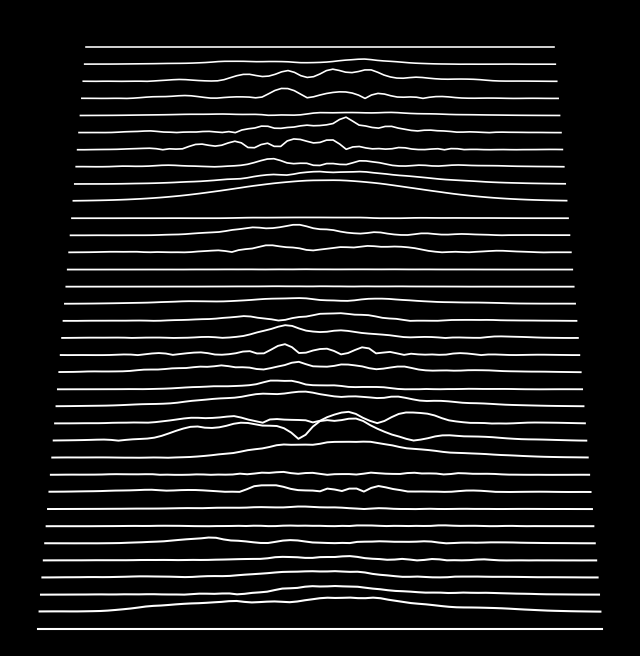

In [74]:
joy_division(audio_file, interval = 10, amplify = 1.5)

#### Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies of a sound signal as they vary with time. It shows how the energy of a signal is distributed across different frequencies over time. Here are the key elements that a spectrogram displays:

1. **Frequency**: The vertical axis represents frequency, usually with lower frequencies at the bottom and higher frequencies at the top. This shows which frequencies are present in the audio signal at any given time.

2. **Time**: The horizontal axis represents time, moving from left to right. This allows you to see how the frequency content of the sound changes over the duration of the recording.

3. **Amplitude or Intensity**: The intensity of different frequencies at different times is represented by the color or brightness of each point in the spectrogram. Typically, darker or more vibrant colors indicate higher energy or amplitude at a particular frequency and time.

A spectrogram is a powerful tool for analyzing the acoustic properties of sounds, particularly for understanding speech, music, and natural sounds. It is widely used in various fields, including linguistics (for phonetic analysis), musicology, bioacoustics, and sound engineering. By providing a visual snapshot of the sound, a spectrogram can reveal intricate details such as the harmonic structure of a musical note, the formant frequencies of vowels in speech, or the varying calls of birds and other animals.

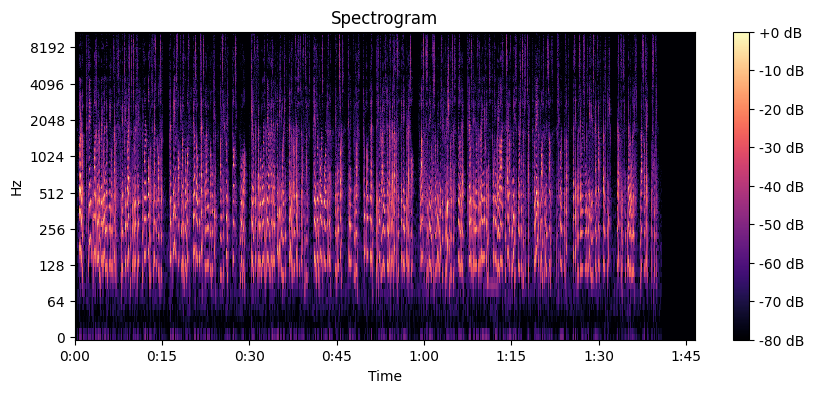

In [75]:
plot_spectrogram(file_path)

#### MFCC 

Mel Frequency Cepstral Coefficients (MFCCs) are a feature representation widely used in the fields of audio and speech processing, especially in speech and speaker recognition systems. Here's what MFCCs show:

    Frequency Features: MFCCs capture the power spectrum of a sound. They are derived from the cepstrum, which is the result of taking the log of the short-term power spectrum and then performing a Fourier transform.

    Mel Scale Emphasis: The "Mel" in MFCC stands for the Mel scale, a scale that mimics the human ear's response more closely than the linearly-spaced frequency bands. This scale is important because human hearing does not perceive frequencies linearly; instead, it is more sensitive to changes in lower frequencies than higher ones. MFCCs transform the frequencies into the Mel scale, making them more representative of how humans hear sounds.

    Representation of Timbral and Textural Characteristics: MFCCs are particularly good at representing the timbre or texture of audio signals, capturing aspects like the tone quality and the sound's color. This makes them very useful in distinguishing different sounds and understanding their characteristics.

    Speech Recognition: In speech processing, MFCCs effectively capture the formant structure (resonant frequencies of the vocal tract) which is crucial for identifying phonemes (basic units of speech sound). This makes them extremely valuable for tasks like speech recognition and speaker identification.
MFCC Values Over Time: The horizontal axis of the plot represents time. It shows how the MFCCs change throughout the duration of the audio file.

MFCC Coefficients: The vertical axis represents the MFCC coefficients. The code calculates 13 coefficients (n_mfcc=13), so there are 13 rows in the plot, each row corresponding to one MFCC. MFCC 1 represents the average power in the audio signal. It can be related to the amplitude of the signal. MFCC 2 and 3 often relate to the broad shape of the spectral envelope. They can indicate aspects like the overall pitch and tone of the sound. Higher-Order MFCCs (4, 5, ...) represent finer spectral details. These coefficients can capture nuances in the sound, such as subtle changes in the vocal tract shape during speech, which are important for distinguishing different phonemes and sounds.

Color-Encoded Magnitude: The color in the plot represents the magnitude of each MFCC coefficient at each point in time. The color scale is shown on the right side of the plot, with the color intensity (or brightness) indicating the magnitude. This is usually in decibels (dB).

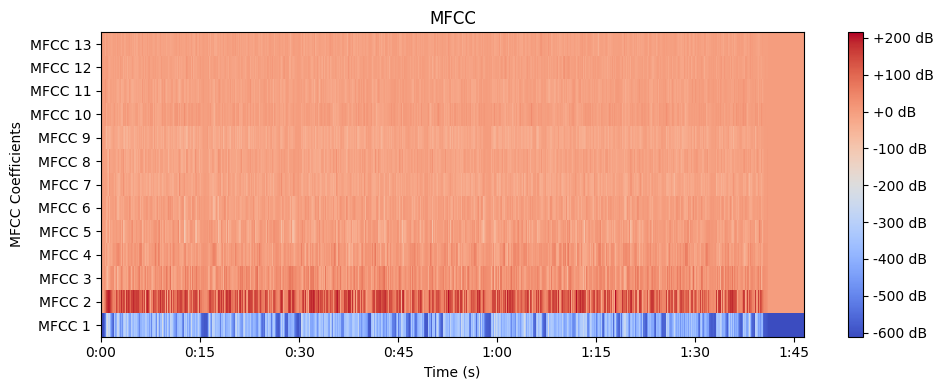

In [76]:
visualize_mfcc(file_path)

#### Pitch 

Pitch, often referred to as the fundamental frequency, is a key characteristic of the human voice that determines how high or low a sound is perceived. It is the rate at which vocal cords vibrate during phonation, and it plays a crucial role in communication, influencing aspects such as melody in speech, intonation, and the perceived emotion or intent behind words spoken. The fundamental frequency for adult male voices typically ranges from about 85 Hz to 155 Hz. The fundamental frequency for adult female voices generally ranges from about 165 Hz to 255 Hz. This range is often cited in various studies and textbooks on voice.

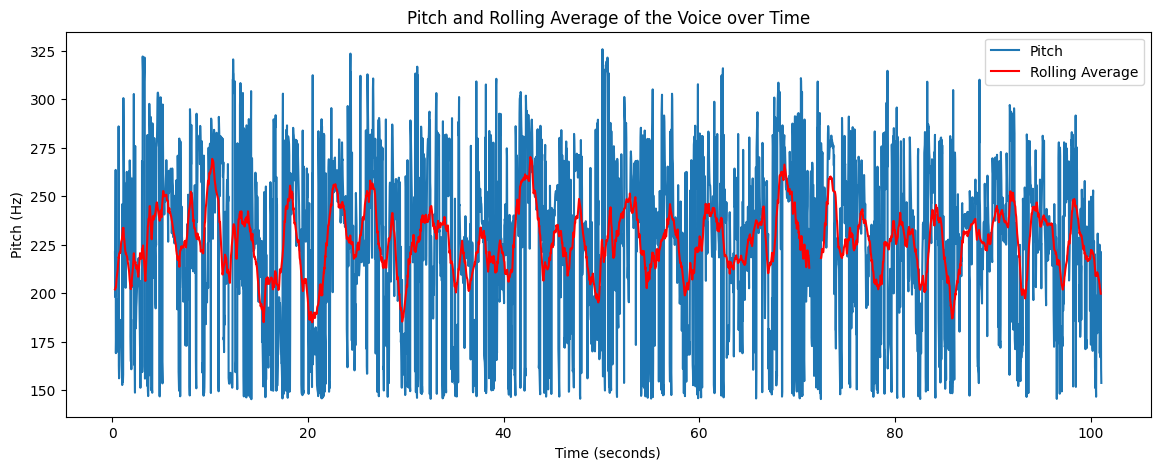

In [77]:
plot_voice_pitch_with_rolling_average(file_path)

## Analysis Time

The analyze_audio function performs a comprehensive analysis of an audio file, providing both transcription and various speech characteristics. It first openAI's whisper (a speech recognition model) to transcribe the audio to text. If analyze_by_sentence is True, it segments the audio by sentences and analyzes each segment separately, otherwise, it analyzes the whole audio file. The analysis includes determining the speaker's gender and emotion, and extracting speech metrics like the number of syllables, pauses, rate of speech, articulation rate, and vocal pitch characteristics (mean, standard deviation, median, minimum, maximum, and quantiles of fundamental frequency). The function returns these details either for each sentence or for the entire audio file, offering insights into the nuances of spoken language and vocal attributes.

In [84]:
analyze_by_sentence = True  # Set to False to analyze the whole audio
file_path = r'C:\Users\...\PietZwart\downloaded_audio\Prime_Minister_Trudeaus_message_on_Remembrance_Day.wav'
analysis_results = analyze_audio(file_path, analyze_by_sentence)
analysis_results

Transcribed text:   Hello everyone. Today we pause to remember the brave women and men who've made the ultimate sacrifice. We pay tribute to our veterans who've served this country and we honor all those who've answered the call to serve. When Canadians have fought during times of war and conflict, they've done so in defense of the values we all hold dear. Values like freedom, democracy and the rule of law. During the first and second world wars in Korea and Afghanistan and in peacekeeping operations, members of our armed forces have stood up for these values. They have endured the horrors of war to defend them. They have borne scars. And too many have given their lives. We owe it to them to stay true to our values and to never forget the sacrifices they've made to protect us all. But while the sacrifices of the Canadian Armed Forces are rooted in history, the tradition of their service lives on today. Members of the Canadian Armed Forces are training the Ukrainian forces, working with

[{'sentence': " Hello everyone. Today we pause to remember the brave women and men who've made the ultimate sacrifice.",
  'gender': 'unknown',
  'emotion': 'unknown',
  'number_of_syllables': 'unknown',
  'number_of_pauses': 'unknown',
  'rate_of_speech': 'unknown',
  'articulation_rate': 'unknown',
  'speaking_duration': 'unknown',
  'original_duration': 'unknown',
  'balance': 'unknown',
  'f0_mean': 'unknown',
  'f0_std': 'unknown',
  'f0_median': 'unknown',
  'f0_min': 'unknown',
  'f0_max': 'unknown',
  'f0_quantile25': 'unknown',
  'f0_quan75': 'unknown'},
 {'sentence': " We pay tribute to our veterans who've served this country and we honor all those who've answered the call to serve.",
  'gender': 'unknown',
  'emotion': 'unknown',
  'number_of_syllables': 'unknown',
  'number_of_pauses': 'unknown',
  'rate_of_speech': 'unknown',
  'articulation_rate': 'unknown',
  'speaking_duration': 'unknown',
  'original_duration': 'unknown',
  'balance': 'unknown',
  'f0_mean': 'unknown',

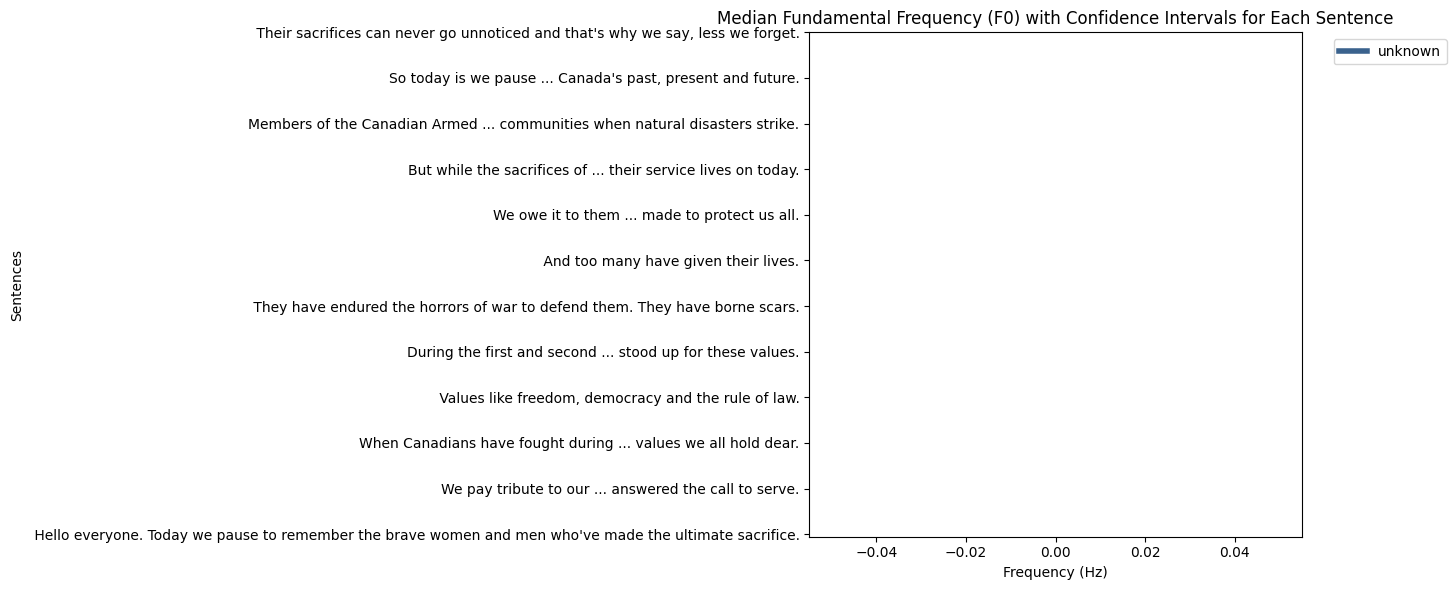

In [85]:
freq_plot(analysis_results)

In [86]:
heat_plot(analysis_results)

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x1500 with 0 Axes>

#### Speaker Diarization

**Why It's Interesting**:
   - Speaker diarization is a key component in many audio analysis applications, such as transcribing meetings or interviews where multiple people are speaking. It allows for more accurate and speaker-specific transcriptions.
   - Visualizing these segments can be very insightful, especially in understanding the dynamics of the conversation, like who dominates the conversation, how interactive it is, and the patterns of dialogue between participants.
   - This process is crucial for audio data analysis in fields like psychology, linguistics, and communication studies, as well as for practical applications like automated meeting minutes and assistive technologies for the hearing impaired.
     
**Speaker Diarization**: 
   - The process of diarization involves identifying and segmenting an audio stream into homogenous segments according to the speaker identity. In simpler terms, it's about determining 'who spoke when' in an audio recording.
   - The `Diarizer` object from a diarization library (possibly `pyAudioAnalysis` or similar) is used here. The model `'xvec'` is specified for embedding (feature extraction), and `'sc'` (possibly spectral clustering) for the clustering method.
   - The `diarize` method is called on the `Diarizer` object with the path to the audio file (`file_path`) and the number of speakers (`num_speakers=2`). This method returns the segments of the audio file where each speaker is talking.

**Reading and Combining the Waveplot**:
   - `sf.read(file_path)` reads the audio file, returning the audio signal (`signal`) and its sample rate (`fs`).
   - `combined_waveplot` is likely a function that plots the waveform of the audio signal and overlays the diarization segments onto this plot. This visualization shows when each speaker is talking during the audio file.

In summary, this code is identifying different speakers in an audio file and then visualizing the timing and duration of each speaker's contributions, which is valuable for understanding spoken interactions in multi-speaker recordings.

In [ ]:
diarization = Diarizer(embed_model='xvec', cluster_method='sc')
segments = diarization.diarize(file_path, num_speakers=2)
segments   

In [ ]:
signal, fs = sf.read(file_path)
combined_waveplot(signal, fs, segments)
plt.show()

#### Speaker Similiarity

The text below is from: https://github.com/OnTrack-UG-Squad/speaker-verification

The Speaker Verification project aims to utilize machine learning technologies to evaluate audio files submitted from a user and obtain a confidence score of how likely it is that the voice in the recording is the user in question.

#### Enroll stage

The enroll workflow requires two parameters, one being a unique numeric id that must be 9 characters long and a path to a wav or flac file of the users voice. Below is the required syntax and format for the this stage.


In [ ]:
!python -m speaker_verification enroll --id 123456789 --audio-path C:/Users/ahnji/OneDrive/Documents/Prototypes/PietZwart/downloaded_audio/Prime_Minister_Trudeaus_message_on_Remembrance_Day.wav

### Validate stage

The validate workflow retrives a user enrollment based on the given id parameter given and then uses the --audio-path input to accept an audio file as speaker input to verify against the given user enrollment.

In [ ]:
!python -m speaker_verification validate --id 123456789 --audio-path C:/Users/ahnji/OneDrive/Documents/Prototypes/PietZwart/downloaded_audio/